# Wind Grid

Testing our controller on realistic wind generated by MIT LL's wind service.

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from utilities import get_agent
from environments import OctorotorEnvSelector
from systems.pid_agent import PIDAgent
from multirotor.helpers import DataLog
from systems.long_blending import softmax

from pymavlink import mavutil
import socket
import struct
import json
from multirotor.coords import body_to_inertial, direction_cosine_matrix

In [21]:
env_selector = OctorotorEnvSelector()
study, lstm_agent, lstm_params = get_agent('windlstm')
lstm_params['steps_u'] = 1
lstm_params['bounding_rect_length']=1000

[I 2023-12-06 18:30:30,880] Using an existing study with name 'windlstm' instead of creating a new one.


In [22]:
# wind_data = pd.read_csv("wind_data.csv")
wind_data = pd.read_csv("./data/wind_data_grid.csv")

In [23]:
wind_positions = wind_data[['X', 'Y']].to_numpy()

In [24]:
square_np = np.array([[500,0,30], [500,500,30], [0,500,30], [0,0,30]])

# square_np = np.asarray([ # defines a real trajectory shown in a NASA paper
#     [164.0146725649829, -0.019177722744643688, 30],
#     [165.6418055187678, 111.5351051245816, 30],
#     [127.3337449710234, 165.73576059611514, 30],
#     [-187.28170707810204, 170.33217775914818, 40],
#     [-192.03130502498243, 106.30660058604553, 40],
#     [115.89920266153058, 100.8644210617058, 30],
#     [114.81859536317643, 26.80923518165946, 30],
#     [-21.459931490011513, 32.60508110653609, 30]
# ])

In [25]:
def determine_wind(xypos):
    # Calculate the Euclidean distances
    distances = np.linalg.norm(wind_positions - xypos, axis=1)
    
    # Find the index of the position with the smallest distance
    closest_position_index = np.argmin(distances)
    
    # Get the closest position
    wind_vec = wind_data.loc[closest_position_index]
    wind_x = wind_vec['Wind X']
    wind_y = wind_vec['Wind Y']

    return wind_x, wind_y

In [26]:
determine_wind(np.array([0,0]))

(-1.47909198916771, -5.934129928880934)

In [27]:
sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
sock.bind(("127.0.0.1", 9002))
# sock.settimeout(0.1)

In [28]:
def changeToJSONString(curr_time, state, accel):
    phys_time = curr_time
    pos = state[0:3].tolist()
    # pos[2] = 0
    velo = state[3:6]
    euler = state[6:9].tolist()
    gyro = state[9:12].tolist()
    accel = accel.tolist()
    accel[2] = -9.8
    # change reference frame / coordinates to make AP requirements
    pos[2] = -1*pos[2]
    pos[0], pos[1] = pos[1], pos[0]
    dcm = direction_cosine_matrix(*euler).astype(np.float32)
    v_inertial = body_to_inertial(velo, dcm).tolist()
    v_inertial[2] = -1*v_inertial[2]
    v_inertial[0], v_inertial[1] = v_inertial[1], v_inertial[0]
    gyro[0], gyro[1] = gyro[1], gyro[0]
    gyro[2] = -1*gyro[2]
    euler[0], euler[1] = euler[1], euler[0]
    euler[2] = -1*euler[2]
    # Build JSON format
    IMU_fmt = {
        "gyro" : gyro,
        "accel_body" : accel
    }
    JSON_fmt = {
        "timestamp" : phys_time,
        "imu" : IMU_fmt,
        "position" : pos,
        "attitude" : euler,
        "velocity" : v_inertial
    }
    JSON_string = "\n" + json.dumps(JSON_fmt,separators=(',', ':')) + "\n"
    return JSON_string

In [29]:
def sendVelToAP(vx, vy, vz): 
    print("heart beat from system (system %u component %u)" % 
        (mavlink_connection.target_system, mavlink_connection.target_component))
    mavlink_connection.mav.send(mavutil.mavlink.MAVLink_set_position_target_local_ned_message(
        10, mavlink_connection.target_system, mavlink_connection.target_component,
        mavutil.mavlink.MAV_FRAME_LOCAL_NED, int(0b110111000111), 
        0, 0, 0, vx, vy, vz, 0, 0, 0, 0, 0
    ))
    msg = mavlink_connection.recv_match(type = 'LOCAL_POSITION_NED', blocking=True)
    print("vx: %u, vy: %u, vz: %u" % (msg.vx, msg.vy, msg.vz))

In [30]:
client_socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
server_address = ('127.0.0.1', 1234)

def send_velocity(vx, vy, vz, client_socket, server_address):
    message = str(vx)+","+str(vy)+","+str(vz)
    message = message.encode('utf-8')
    client_socket.sendto(message, server_address)

In [31]:
def receive_motor_commands():
    data, addr = sock.recvfrom(100)
    parse_format = 'HHI16H'
    magic = 18458
    unpacked_data = struct.unpack(parse_format, data)
    pwm = np.array(unpacked_data[3:11]) # Array of motor commands recieved
    action = (pwm-1000)*0.575 # Translate PWM ESC to motor speeds in rad/s
    # print(1, end="")
    # print(action)
    return action, addr

In [32]:
def send_state(accel, curr_time, state, addr):
    # data, addr = sock.recvfrom(100)
    JSON_string = changeToJSONString(curr_time, state, accel)
    # print(JSON_string)
    logToFile(JSON_string, "JSONLog.txt")
    # print(0, end="")
    sock.sendto(bytes(JSON_string,"ascii"), addr)

In [33]:
def build_ap_state(vehicle):
    return np.array([vehicle.position[0], vehicle.position[1], vehicle.position[2],
                    vehicle.velocity[0], vehicle.velocity[1], vehicle.velocity[2],
                    vehicle.orientation[0], vehicle.orientation[1], vehicle.orientation[2],
                    vehicle.angular_rate[0], vehicle.angular_rate[1], vehicle.angular_rate[2]])

In [34]:
def clear_file(file_path):
    file_path="logs/"+file_path
    with open(file_path, 'w') as file:
        pass

In [35]:
def logToFile(string_to_log, file_path):
    file_path="logs/"+file_path
    with open(file_path, 'a') as file:
        file.write(string_to_log + '\n')

In [36]:
# Evaluates all saved agents with their params on a wind range
def run_wind_grid(agent, params):
    clear_file('JSONLog.txt')
    env = env_selector.get_env("ardupilot_400hz", params, [(0,0),(0,0),(0,0)], square_np, has_turbulence=False, start_alt=0)

    done = False
    state = env.reset()
    state = np.array(state, dtype=np.float32)
    log = DataLog(env.base_env.vehicle, env.base_env.ctrl,
                      other_vars=('reward',))

    ct = 0
    ap_state = np.zeros(12, dtype=np.float32)
    acc = np.zeros(3, dtype=np.float32)
    acc[2] = -9.8
    while env.base_env.vehicle.position[2] < 29.5:
        speeds, addr = receive_motor_commands()
        
        state, reward, done, info = env.step(speeds)
        state = np.array(state, dtype=np.float32)
        print(ct, state[6:12])
        # print(env.base_env.vehicle.position, speeds, env.base_env.vehicle.velocity)
        # acc = env.base_env.vehicle.dxdt_speeds(0, state, speeds)[3:6]
        # acc[2] = -9.8
        ap_state = build_ap_state(env.base_env.vehicle)
        # print(env.base_env.
        send_state(acc, ct, ap_state, addr)
        logToFile(str(speeds), 'JSONLog.txt')
        
        ct += 1/400

    print("Reached height")
    
    winds = []
    curr_time = ct
    # accel = np.array([0,0,0], dtype=np.float32)
    
    while not done:
        xy_pos = np.array([env.base_env.vehicle.position[0],env.base_env.vehicle.position[1]])
        # x_wind, y_wind = determine_wind(xy_pos)
        # env.base_env.wind_x = x_wind
        # env.base_env.wind_y = y_wind
        # winds.append([x_wind, y_wind])
        # env.base_env.get_turbulence(env.base_env.prev_waypt, env.base_env.next_waypt)

        pos_ref = env.base_env.calculate_safe_sliding_bound(env.base_env.next_waypt, env.base_env.prev_intersection_point, distance=env.base_env.window_distance)
        xy_target_vel = env.base_env.ctrl.ctrl_p.step(pos_ref[0:2], env.base_env.vehicle.position[0:2], dt=env.base_env.dt)
        z_target_vel = env.base_env.ctrl.ctrl_z.step(pos_ref[2:], env.base_env.vehicle.position[2:], dt=env.base_env.dt)
        target_vel = np.hstack([xy_target_vel, z_target_vel])
        if i % 200 == 0:
            delta_vel = agent.predict(state, deterministic=True)[0]
        
        vx, vy, vz = target_vel + delta_vel
        ap_state = build_ap_state(env.base_env.vehicle)
        
        send_state(accel, curr_time, ap_state, addr)
        send_velocity(vx, vy, vz, client_socket, server_address)
        
        speeds, addr = receive_motor_commands()
        
        state, reward, done, info = env.step(speeds)
        state = np.array(state, dtype=np.float32)
        
        accel = env.base_env.vehicle.dxdt_speeds(0, state, speeds)[3:6]
        accel[2] = -9.8
        log.log(reward=reward)
        print(env.base_env.vehicle.position)
        curr_time += 1/400

    log.done_logging()

    return log, winds

In [37]:
# done = False
# env = env_selector.get_env("ardupilot_400hz", lstm_params, [(0,0),(0,0),(0,0)], square_np, has_turbulence=False, start_alt=0)
# state = env.reset()
# state = np.array(state, dtype=np.float32)
# log = DataLog(env.base_env.vehicle, env.base_env.ctrl,
#                   other_vars=('reward',))

# for i in range(200):
#     state, reward, done, info =  env.step(np.array([86.25]*8, dtype=np.float32))
#     state = np.array(state, dtype=np.float32)
#     print(env.base_env.vehicle.state)

# log.done_logging()

In [ ]:
wind_log, winds = run_wind_grid(lstm_agent, lstm_params)

/home/courseac/miniconda3/envs/supervisor-control/lib/python3.9/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


0 [0. 0. 0. 0. 0. 0.]


/home/courseac/miniconda3/envs/supervisor-control/lib/python3.9/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


0.0025 [0. 0. 0. 0. 0. 0.]
0.005 [0. 0. 0. 0. 0. 0.]
0.0075 [0. 0. 0. 0. 0. 0.]
0.01 [0. 0. 0. 0. 0. 0.]
0.0125 [0. 0. 0. 0. 0. 0.]
0.015000000000000001 [0. 0. 0. 0. 0. 0.]
0.0175 [0. 0. 0. 0. 0. 0.]
0.02 [0. 0. 0. 0. 0. 0.]
0.0225 [0. 0. 0. 0. 0. 0.]
0.024999999999999998 [0. 0. 0. 0. 0. 0.]
0.027499999999999997 [0. 0. 0. 0. 0. 0.]
0.029999999999999995 [0. 0. 0. 0. 0. 0.]
0.032499999999999994 [0. 0. 0. 0. 0. 0.]
0.034999999999999996 [0. 0. 0. 0. 0. 0.]
0.0375 [0. 0. 0. 0. 0. 0.]
0.04 [0. 0. 0. 0. 0. 0.]
0.0425 [0. 0. 0. 0. 0. 0.]
0.045000000000000005 [0. 0. 0. 0. 0. 0.]
0.04750000000000001 [0. 0. 0. 0. 0. 0.]
0.05000000000000001 [0. 0. 0. 0. 0. 0.]
0.05250000000000001 [0. 0. 0. 0. 0. 0.]
0.055000000000000014 [0. 0. 0. 0. 0. 0.]
0.057500000000000016 [0. 0. 0. 0. 0. 0.]
0.06000000000000002 [0. 0. 0. 0. 0. 0.]
0.06250000000000001 [0. 0. 0. 0. 0. 0.]
0.06500000000000002 [0. 0. 0. 0. 0. 0.]
0.06750000000000002 [0. 0. 0. 0. 0. 0.]
0.07000000000000002 [0. 0. 0. 0. 0. 0.]
0.07250000000000002 [

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

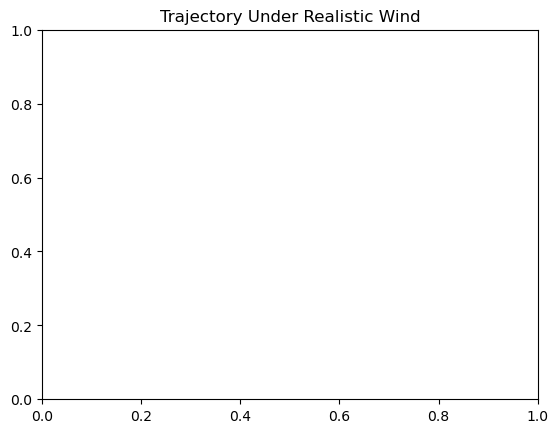

In [38]:
plt.title("Trajectory Under Realistic Wind")
plt.plot(wind_log.x, wind_log.y)
plt.xlabel("X position (m)")
plt.ylabel("Y position (m)")

In [ ]:
len(wind_log.t)

In [ ]:
plt.plot(wind_log.z)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_title("Trajectory Over Golf Course")
ax.plot(wind_log.x, wind_log.y, wind_log.z, label='PID Tarot', alpha=0.5) # PID tarot
ax.scatter(square_np[:, 0], square_np[:, 1], square_np[:, 2], marker='x', color="red")

ax.legend(loc='lower left')
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")
ax.set_zlim(390, 410)
ax.view_init(20, 45)
# plt.savefig('./figures/n_nasa.png')
plt.show()
